#Setup and Installation to run Yolov4

Following cell will clone darknet from AlexeyAB's famous repository and we will be adjusting the Makefile to enable OPENCV and GPU for darknet and then build darknet.

In [ ]:
# clone darknet repository
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

In [ ]:
# make darknet (builds darknet so that you can then use the darknet executable file to run or train object detectors)
!make


#Download pre-trained YOLOv4 weights

YOLOv4 has been trained already on the coco dataset which has 80 classes that it can predict. We will take these pretrained weights to see how it gives result on some of the images.

In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

## Display functions to display the predicted class

In [ ]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

#### Darknet folder provides some of the images in the data subfolder and we will be using the same image to predict on the pretrained model

In [ ]:
# run darknet detection on test images
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/person.jpg

### Displaying image using our display function

In [ ]:
imShow('predictions.jpg')

# Using Yolov4 for detecting different classes in invoice

We will create our own custom YOLOv4 object detector to recognize Invoice number,Date and Amount from the Invoice! 

We will be needing following things to create our custom object detector:

*   Labeled Custom Dataset
*   Custom .cfg file
*   obj.data and obj.names files
*   train.txt file and test.txt file

# Step 1: Data collection and Labeling with LabelImg
To create a custom object detector we need a good dataset of images and labels for better training of the model so we will label our images using annotation tools LabelImg

Now  we have a folder as Invoice_pro having subfolder as obj which indicate train dataset and test which indicate validation dataset. Hence we will be converting it into zip file and uploading it in data subfolder of darknet.

Unzip the datasets and their contents so that they can be seen as a folder in /darknet/data/ folder

In [ ]:
!unzip /content/darknet/data/obj.zip  -d /content/darknet/data/

In [ ]:
!unzip /content/darknet/data/test.zip  -d /content/darknet/data/

# Step 2: Configuring Files for Training
This step involves configuring custom .cfg, obj.data, obj.names, train.txt and test.txt files.

It is important to configure all these files without any typos as small errors can cause major problems.



# 1) Config File

Now you need to edit yolov4-custom.cfg to fit your needs based on your object detector. 

First download yolov4-custom.cfg from path /darknet/cfg/yolov4-custom.cfg and change following parameters.



 **batch = 64** and **subdivisions = 16** gives best results but if you run into any issues then make subdivisions to 32





# Configuring all the needed variables based on class

width = 416

height = 416

*(these can be any multiple of 32, 416 is standard, improvement in the results can happen if we increase the size of the image but will slow down training)*

max_batches = (# of classes) * 2000

*(But it shouldnt be less than 6000 so if you are training for 1, 2, or 3 classes it will be 6000, however detector for 5 classes would have max_batches=10000)*

steps = (80% of max_batches), (90% of max_batches)

*(If your max_batches = 10000, then steps = 8000, 9000*)

filters = (# of classes + 5) * 3

*(If you are training for one class then your filters = 18, but if you are training for 4 classes then your filters = 27)*

Change the name to yolov4-obj.cfg and now upload at the same place.

# 2) obj.names and obj.data 

Create a new file called **obj.names** where you will have one class name per line in the same order as your classes.txt from the dataset generation step.


 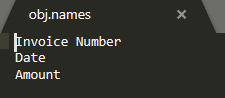

You will also need to create a obj.data file and fill it in like this(change your class number accordingly. 

This backup path is where we will save the weights to of our model throughout training.

Upload obj.names and obj.data in data subfolder of darknet



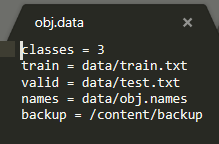

## 3) Generating train.txt and test.txt

The last configuration files needed before we can begin to train our custom detector are the train.txt and test.txt files which will have paths to all our training images and valdidation images.

To create the same we will be using two script for generating train and text text files.

In [ ]:
!python /content/generate_train.py
!python /content/generate_test.py

In [ ]:
# verifying if train.txt and test.txt can be seen in our darknet/data folder
!ls /content/darknet/data/

# Step 4: Download pre-trained weights for the convolutional layers.

This step downloads the weights for the convolutional layers of the YOLOv4 network. By using these weights it helps your custom object detector to be way more accurate and not have to train as long.

In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

# Step 5: Training  Your Custom Object Detector!

We are now ready to train our custom YOLOv4 object detector on Amount,Invoice Number and Date classes. So run the following command.( -dont_show flag stops chart from popping up since Colab Notebook can't open images on the spot,
-map flag overlays mean average precision on chart to see the accuracy)


```
!./darknet detector train <path to obj.data> <path to custom config> yolov4.conv.137 -dont_show -map
```

In [ ]:
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg yolov4.conv.137 -dont_show -map

In [ ]:
# show chart.png of how custom object detector did with training
imShow('chart.png')

If for some reason you get an error or your Colab goes idle during training, you have not lost your partially trained model and weights because every 100 iterations a weights file called **yolov4-obj_last.weights** is saved to **content/backup/** folder.

We can kick off training from our last saved weights file so that we don't have to restart!

Just run the following command but with your backup location.


```
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg /content/backup/yolov4-obj_last.weights -dont_show
```

# Step 6: Checking the Mean Average Precision (mAP) of Your Model

If you didn't run the training with the '-map- flag added then you can still find out the mAP of your model after training. Run the following command on any of the saved weights from the training to see the mAP value for that specific weight's file. 


In [ ]:
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg /content/backup/yolov4-obj_last.weights

# Step 7: Run Your Custom Object Detector!!!
You have done it! You now have a custom object detector to make your very own detections.

In [ ]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-obj.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-obj.cfg
%cd ..

Run your custom detector with this command

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /content/drive/MyDrive/yolov4-obj_best.weights /content/images/basic-invoice.png -thresh 0.4
imShow('predictions.jpg')

# Step 9: Multiple Images at Once
YOLOv4 object detections can be run on multiple images at once. This is done through having a text file which has the paths to several images that you want to have the detector run on.

So we will be creating a images.txt file for the same and uploading it here



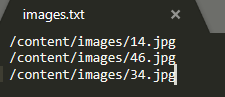

## Save Results to .JSON File
Here is an example of saving the multiple image detections to a .JSON file.

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /content/drive/MyDrive/yolov4-obj_best.weights -dont_show -out /content/result.json < /content/images.txt

## Using result.json to crop the bounding box of the predicted classes of each images from images folder which we will pass to pytesseract for image to text conversion.

In [ ]:
import cv2
import os
import json

#Reading json file which contains details of detected classes
with open('/content/result.json', 'r') as j:
    contents = json.loads(j.read())
    
bb=dict()
count = 0

#Looping for reading and cropping the detected classes based on their coordinates value which is stored in result.json

for i in contents:
    im = cv2.imread('/content/images/'+ i['filename'][16:])
    print('/content/images/'+ i['filename'][16:])
    for obj in i['objects']:
        if obj['name']=='Amount':
            bb=obj['relative_coordinates']
            x = int((bb['center_x'] - bb['width']/2) * im.shape[1])
            y = int((bb['center_y'] - bb['height']/2) * im.shape[0])
            w = int(bb['width'] * im.shape[1])
            h = int(bb['height'] * im.shape[0])
            cropped = im[y:y+h,x:x+w]
            cv2.imwrite('/content/images/'+'Amount_'+i['filename'][16:],cropped)
            
        elif obj['name']=='Invoice Number':
            bb=obj['relative_coordinates']
            x = int((bb['center_x'] - bb['width']/2) * im.shape[1])
            y = int((bb['center_y'] - bb['height']/2) * im.shape[0])
            w = int(bb['width'] * im.shape[1])
            h = int(bb['height'] * im.shape[0])
            cropped = im[y:y+h,x:x+w]
            print('/content/images/'+'Invoice Number_'+i['filename'][16:])
            cv2.imwrite('/content/images/'+'Invoice Number_'+ i['filename'][16:],cropped)
            
        elif obj['name']=='Date':
            bb=obj['relative_coordinates']
            x = int((bb['center_x'] - bb['width']/2) * im.shape[1])
            y = int((bb['center_y'] - bb['height']/2) * im.shape[0])
            w = int(bb['width'] * im.shape[1])
            h = int(bb['height'] * im.shape[0])
            cropped = im[y:y+h,x:x+w]
            cv2.imwrite('/content/images/'+'Date_'+i['filename'][16:],cropped)
        
            

Now passing we will be passing all the cropped predicted classes of each images into pytesseract